<a href="https://colab.research.google.com/github/Anna4142/Gans/blob/main/BEAUTYSCORE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import pandas as pd
import numpy as np
from keras.utils import load_img, img_to_array
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import cv2

import scipy.io
import numpy as np

from datetime import datetime, timedelta
import time

import tensorflow as tf

import keras
import keras.utils as image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import cv2

import pandas as pd

##DATA

In [ ]:
!gdown --id 1w0TorBfTIqbquQVd6k3h_77ypnrvfGwf

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1w0TorBfTIqbquQVd6k3h_77ypnrvfGwf
To: /content/SCUT-FBP5500_v2.1.zip
100% 180M/180M [00:00<00:00, 197MB/s]


In [ ]:
!unzip /content/SCUT-FBP5500_v2.1.zip

Streaming output truncated to the last 5000 lines.
  inflating: SCUT-FBP5500_v2/Images/AF382.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF401.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF503.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF515.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF529.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF55.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF620.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF633.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF635.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF64.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF67.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF699.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF746.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF747.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF764.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF768.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF781.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF796.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF81.jpg  
  inflating: SCUT-FBP5500_v2/Images/AF148

In [ ]:
train_df = pd.read_csv("SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/train.txt", sep=" ", names=["image", "score"])
test_df = pd.read_csv("SCUT-FBP5500_v2/train_test_files/split_of_60%training and 40%testing/test.txt", sep=" ", names=["image", "score"])

In [ ]:
train_df['purpose'] = 'train'
test_df['purpose'] = 'test'

In [ ]:
np.random.seed(17)
val_set_size = int((40*train_df.shape[0])/100)
val_idx = np.random.choice(train_df.shape[0], size=val_set_size)

In [ ]:
train_df.loc[val_idx, 'purpose'] = 'validation'

In [ ]:
df = pd.concat([train_df, test_df])

In [ ]:
del train_df, test_df

In [ ]:
df.sample(5)[['image', 'score', 'purpose']]

,image,score,purpose
1150,CM537.jpg,2.883333,test
2378,AF1558.jpg,3.700000,train
959,AM1502.jpg,2.666667,train
1225,AM1763.jpg,3.750000,test
99,CM726.jpg,3.433333,test


In [ ]:
df.iloc[[918, 1459, 261, 999, 2129]][['image', 'score', 'purpose']]

,image,score,purpose
918,AM1976.jpg,3.250000,train
1459,AM1191.jpg,2.533333,train
261,AF1477.jpg,4.100000,train
999,AF1494.jpg,3.700000,validation
2129,AM453.jpg,2.733333,train


In [ ]:
df.shape

(5500, 3)

In [ ]:
pd.DataFrame(df.purpose.value_counts()).rename(columns = {"purpose": "instances"})

,instances
train,2219
test,2200
validation,1081


array([[<Axes: title={'center': 'score'}>]], dtype=object)

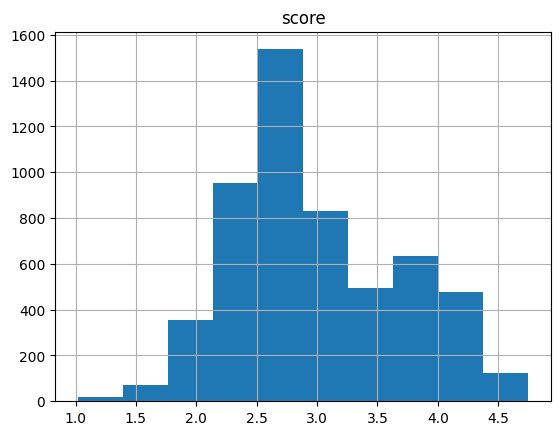

In [ ]:
df.hist()

##Demography

In [ ]:
def findRace(image_name):
    if image_name[0:1] == "C":
        return "Caucasian"
    else:
        return "Asian"

def findGender(image_name):
    if image_name[1:2] == "M":
        return "Male"
    else:
        return "Woman"

In [ ]:
df["race"] = df["image"].progress_apply(findRace)
df["gender"] = df["image"].progress_apply(findGender)

100%|██████████| 5500/5500 [00:00<00:00, 806907.27it/s]


In [ ]:
pd.DataFrame(100*df.race.value_counts()/df.race.value_counts().sum()).rename(columns = {"race": "instance_percentage"})

,instance_percentage
Asian,72.727273
Caucasian,27.272727


In [ ]:
pd.DataFrame(100*df.gender.value_counts()/df.gender.value_counts().sum()).rename(columns = {"gender": "instance_percentage"})

,instance_percentage
Male,50.0
Woman,50.0


##Image Pixels

In [ ]:
def retrievePixels(img_name):
    path = "SCUT-FBP5500_v2/Images/%s" % (img_name)
    img = image.load_img(path, grayscale=False, target_size=(224, 224))
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x

In [ ]:
df['pixels'] = df['image'].apply(retrievePixels)
#df['pixels'] = df['image'].progress_apply(retrievePixels)

In [ ]:
df.head()

,image,score,purpose,race,gender,pixels
0,CM148.jpg,3.516667,train,Caucasian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
1,AF1048.jpg,3.150000,validation,Asian,Woman,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,AM878.jpg,2.566667,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
3,AM1633.jpg,3.133333,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
4,AM1176.jpg,1.950000,validation,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."


In [ ]:
features = []
pixels = df['pixels'].values
for i in range(0, pixels.shape[0]):
    features.append(pixels[i])

In [ ]:
tic = time.time()

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

toc = time.time()

print("converted to numpy in ",toc-tic,"seconds")

converted to numpy in  0.9576461315155029 seconds


##Modelling

In [ ]:
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

###Base vgg face model

In [ ]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [ ]:
!gdown --id  1tQGrH9BczlfxJX3uf-PEnu07Hllo2frz

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tQGrH9BczlfxJX3uf-PEnu07Hllo2frz
To: /content/vgg_face_weights.h5
100% 580M/580M [00:02<00:00, 204MB/s]


In [ ]:
#pre-trained weights of vgg-face model. 
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('/content/vgg_face_weights.h5')

##Normalization

In [ ]:
print("max score is ", df.score.max())
print("min score is ", df.score.min())

#target normalization
max_limit = df.score.max()
min_limit = df.score.min()

#sigmoid removed in the final layer
#df.score = (df.score - min_limit) / (max_limit - min_limit)

# input normalization
features = features / 255

max score is  4.75
min score is  1.016667


##Transfer learning

In [ ]:
num_of_classes = 1 #this is a regression problem

In [ ]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Flatten()(model.layers[-4].output)
base_model_output = Dense(num_of_classes)(base_model_output)

#Mehmet Gonen recommended to remove sigmoid for a regression problem
#"You could but you should not"
#Should not I normalize output in this case?
#base_model_output = Activation('sigmoid')(base_model_output)

beauty_model = Model(inputs=model.input, outputs=base_model_output)

###Training

In [ ]:
beauty_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

In [ ]:
checkpointer = ModelCheckpoint(
    filepath='beauty_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [ ]:
df.head()

,image,score,purpose,race,gender,pixels
0,CM148.jpg,3.516667,train,Caucasian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
1,AF1048.jpg,3.150000,validation,Asian,Woman,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,AM878.jpg,2.566667,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
3,AM1633.jpg,3.133333,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
4,AM1176.jpg,1.950000,validation,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."


In [ ]:
train_idx = df[(df['purpose'] == 'train')].index
val_idx = df[(df['purpose'] == 'validation')].index
test_idx = df[(df['purpose'] == 'test')].index

In [ ]:
score = beauty_model.fit(
    features[train_idx], df.iloc[train_idx].score
    , epochs=5000
    , validation_data=(features[val_idx], df.iloc[val_idx].score)
    , callbacks=[checkpointer, earlyStop]
)

Epoch 1/5000
70/70 [==============================] - ETA: 0s - loss: 0.8806
Epoch 1: val_loss improved from inf to 0.20988, saving model to beauty_model.hdf5
70/70 [==============================] - 19s 120ms/step - loss: 0.8806 - val_loss: 0.2099
Epoch 2/5000
69/70 [============================>.] - ETA: 0s - loss: 0.2989
Epoch 2: val_loss did not improve from 0.20988
70/70 [==============================] - 4s 51ms/step - loss: 0.2990 - val_loss: 0.2852
Epoch 3/5000
69/70 [============================>.] - ETA: 0s - loss: 0.2592
Epoch 3: val_loss improved from 0.20988 to 0.19713, saving model to beauty_model.hdf5
70/70 [==============================] - 7s 94ms/step - loss: 0.2588 - val_loss: 0.1971
Epoch 4/5000
69/70 [============================>.] - ETA: 0s - loss: 0.2643
Epoch 4: val_loss improved from 0.19713 to 0.15628, saving model to beauty_model.hdf5
70/70 [==============================] - 7s 94ms/step - loss: 0.2658 - val_loss: 0.1563
Epoch 5/5000
69/70 [=================

In [ ]:
best_iteration = np.argmin(score.history['val_loss'])+1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

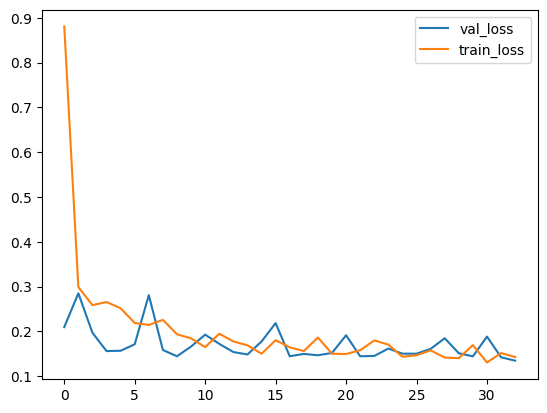

In [ ]:
plt.plot(val_scores, label='val_loss')
plt.plot(train_scores, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
#restore the best weights
from keras.models import load_model 
beauty_model = load_model("beauty_model.hdf5")
model_json = model.to_json()
with open("/content/gdrive/MyDrive/ColabNotebooks/METAPIX/task2attractiveness/model_json", "w") as json_file:
    json_file.write(model_json)
beauty_model.save('/content/gdrive/MyDrive/ColabNotebooks/METAPIX/task2attractiveness/beauty_model.hdf5')
beauty_model.save_weights('/content/gdrive/MyDrive/ColabNotebooks/METAPIX/task2attractiveness/beauty_model_weights.h5')

In [ ]:
#load weights
#load model
!gdown --id 1JbvLR2mTslLMR-5dhB2GMA08zTeK9SgD
!gdown --id 1-1CxvTEiS2cgNPbcwchdVMXfEsjF3sjl

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1JbvLR2mTslLMR-5dhB2GMA08zTeK9SgD
To: /content/beauty_model.h5
100% 537M/537M [00:07<00:00, 72.9MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-1CxvTEiS2cgNPbcwchdVMXfEsjF3sjl
To: /content/beauty_model.hdf5
100% 1.49G/1.49G [00:05<00:00, 254MB/s]


In [ ]:
# load json and create model
from keras.models import load_model
beauty_model = load_model('/content/beauty_model.hdf5')
# load weights into new model
beauty_model.load_weights("/content/beauty_model.h5")
print("Loaded model from disk")

Loaded model from disk


##Performance

In [ ]:
actuals = df.iloc[test_idx].score.values
predictions = beauty_model.predict(features[test_idx])

NameError: ignored

In [ ]:
perf = pd.DataFrame(actuals, columns = ["actuals"])
perf["predictions"] = predictions

In [ ]:

print("pc: ",perf[['actuals', 'predictions']].corr(method ='pearson').values[0,1])
print("mae: ", mean_absolute_error(actuals, predictions))
print("rmse: ", sqrt(mean_squared_error(actuals, predictions)))

pc:  0.9268024191451562
mae:  0.19497481947385098
rmse:  0.26766354934985354


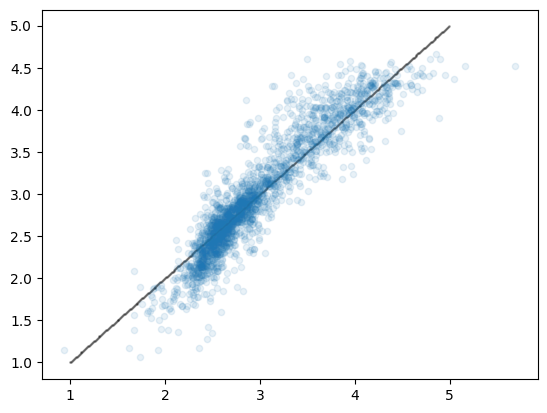

In [ ]:
best_predictions = []
for i in np.arange(int(min_limit), int(max_limit) + 1, 0.01):
    best_predictions.append(round(i, 2))

plt.scatter(best_predictions, best_predictions, s=1, color = 'black', alpha=0.3)
plt.scatter(predictions, actuals, s=20, alpha=0.1)

##Prediction

In [ ]:
def plotImage(df, idx):
    print("beauty score: ",df.iloc[idx].score)
    img = (df.iloc[idx]['pixels'].reshape([224, 224, 3])) / 255
    plt.imshow(img)
    plt.show()
    print("----------------")

In [ ]:
def findPrediction(df, idx):
    img = df.iloc[idx].pixels / 255
    img = img.reshape(224, 224, 3)
    img = np.expand_dims(img, axis = 0)
    prediction = beauty_model.predict(img)[0, 0]
    return prediction

In [ ]:
sample_set = df.sort_values(by=['score'], ascending=False).head(15)
sample_set = sample_set.reset_index(drop=True)

In [ ]:
sample_set.head()

,image,score,purpose,race,gender,pixels
0,AF1973.jpg,4.750000,test,Asian,Woman,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
1,CF609.jpg,4.700000,test,Caucasian,Woman,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,AM22.jpg,4.700000,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
3,AM390.jpg,4.683333,test,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
4,AM1624.jpg,4.666667,train,Asian,Male,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."


1/1 [==============================] - 0s 238ms/step
prediction:  4.172017
beauty score:  4.7


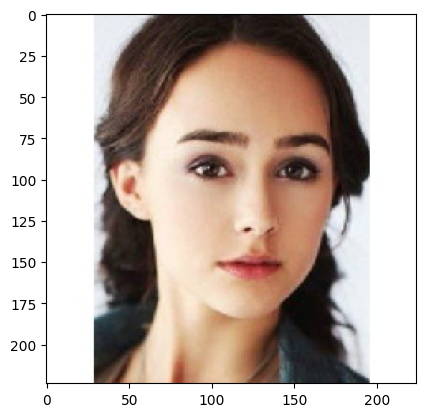

----------------
1/1 [==============================] - 0s 21ms/step
prediction:  4.597462
beauty score:  4.65


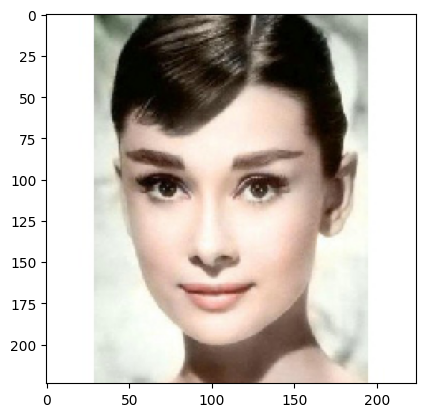

----------------
1/1 [==============================] - 0s 22ms/step
prediction:  4.374504
beauty score:  4.65


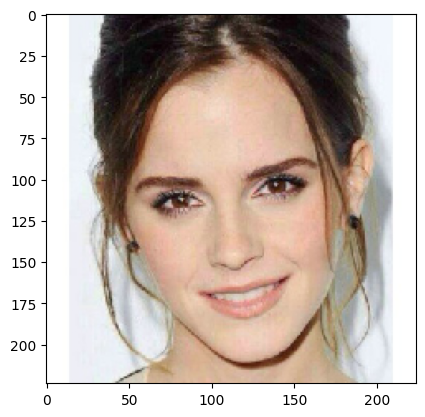

----------------
1/1 [==============================] - 0s 22ms/step
prediction:  4.3234396
beauty score:  4.633333


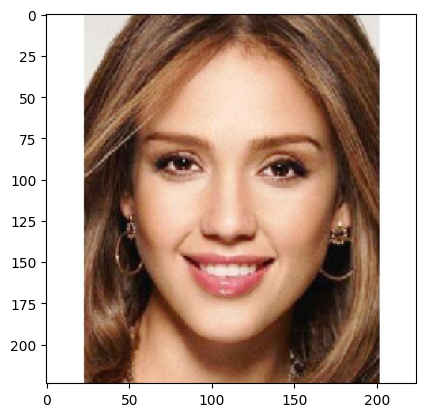

----------------
1/1 [==============================] - 0s 21ms/step
prediction:  4.9018507
beauty score:  4.6


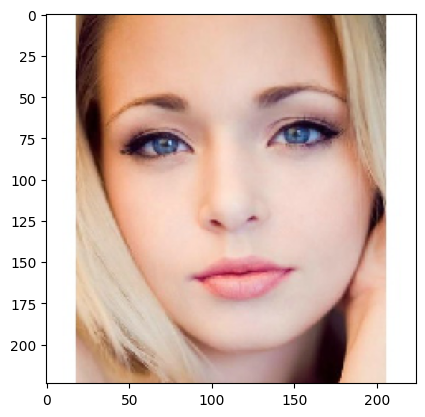

----------------


In [ ]:
idx_list = sample_set.sort_values(by=['score'], ascending=False).index

index = 0
for idx in idx_list:
    if sample_set.iloc[idx].race != 'Asian':
        print("prediction: ",findPrediction(sample_set, idx))
        plotImage(sample_set, idx)
        index = index + 1
        
        if index == 5:
            break

##Load your photo

In [ ]:
!gdown --id 1TbzROGflBxOLc_Yc4D7T1cZUA74RJSCU


/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TbzROGflBxOLc_Yc4D7T1cZUA74RJSCU
To: /content/testphoto.jpg
100% 16.1k/16.1k [00:00<00:00, 29.5MB/s]


In [ ]:
path = '/content/testphoto.jpg'
img = image.load_img(path, grayscale=False, target_size=(224, 224, 3))
img = image.img_to_array(img).reshape(1, -1)[0]
img = img.reshape(224, 224, 3)
img = img / 255
  #-----------------------   
plt.imshow(img)
plt.show()
    
   
    
img = np.expand_dims(img, axis=0)

prediction = beauty_model.predict(img)[0, 0]
prediction = 100*(prediction - min_limit) / (max_limit - min_limit)

print("Beauty score: ",int(prediction), "/100")
print("---------------------------")

AttributeError: ignored

In [ ]:
!gdown --id 1ypDT2TIJqZS7pJcD4TXsjWb-sr7bOA2N

In [ ]:
path = '/content/annehathway.jpg'
img = image.load_img(path, grayscale=False, target_size=(224, 224, 3))
img = image.img_to_array(img).reshape(1, -1)[0]
img = img.reshape(224, 224, 3)
img = img / 255
  #-----------------------   
plt.imshow(img)
plt.show()
    
   
    
img = np.expand_dims(img, axis=0)

prediction = beauty_model.predict(img)[0, 0]
prediction = 100*(prediction - min_limit) / (max_limit - min_limit)

print("Beauty score: ",int(prediction), "/100")
print("---------------------------")